In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

%matplotlib inline
import matplotlib.pyplot as plt

from tqdm import tqdm

**Перед тем как начать выполнять задание, определитесь где вы будете обучать модель: на GPU или CPU.**

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

cuda
Tue May 28 23:13:10 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+--------------------

# Проблема затухания градиента

Рассмотрим проблему затухания градиента во время обучений неройнных сетей

**Залача 1:** Определите модель со следующей структурой:
1. Вход и выход заданы - линейными слоями (nn.Linear)
2. Скрытые слои - в виде линейных слоев в nn.ModuleList

In [4]:
# Класс модели:
class DeepMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_hidden):
        super(DeepMLP, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_hidden)])
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.input_layer(x)
        for hidden_layer in self.hidden_layers:
            x = F.sigmoid(hidden_layer(x))
        x = self.output_layer(x)
        return x


**Вопрос:** Сколько параметров (весов) будет иметь эта модель, если инициализировать ее следующие аргументами:

input_size=3,
hidden_size=6,
output_size=7,
n_hidden=1

**Пример ответа:** `123`

In [5]:
model = DeepMLP(input_size=3, hidden_size=6, output_size=7, n_hidden=1)

answer = sum(p.numel() for p in model.parameters() if p.requires_grad)
answer   ### здесь должен быть выведен ответ

115

**Задача 2:** Вычислите среднее по градиенту в первом скрытом (!!!) слое.

**Вопрос:** Каково это значение?

**Пример ответа:** `1.2`

In [6]:
torch.manual_seed(42)

model = DeepMLP(28 * 28, 6, 7, 1)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer.zero_grad()
out = model(torch.rand((1, 28 * 28)))
loss = criterion(out, torch.rand((1, )).long())

loss.backward()

In [7]:
answer  = torch.mean(model.hidden_layers[0].weight.grad).item()
answer   ### здесь должен быть выведен ответ

0.0010385033674538136

Теперь попробуйте обучить небольшую модель состоящую всего-лишь из трех скрытых слоев.

**Задача 3:** Создайте объект класса модели DeepMLP

In [16]:
torch.manual_seed(42)

# Инициализация модели, лосс функции и оптимайзера:
input_size = 28 * 28 # MNIST image size
hidden_size = 32
output_size = 10
n_hidden=3          # небольшая модель всего из трех скрытых слоев
model = DeepMLP(input_size, hidden_size, output_size, n_hidden).to(device)

**Вопрос:** Какова сумма всех выходов модели для случайного входного тензора test_data?

**Пример ответа:** `1.234`

In [17]:
test_data = torch.rand((1, 28*28)).to(device)

answer = model(test_data).sum()
answer   ### здесь должен быть выведен ответ

tensor(-0.5516, device='cuda:0', grad_fn=<SumBackward0>)

Теперь попробуем имплементировать цикл обучения и затем обучить модель на датасете MNIST. Но для начала давайте скачаем и подготовим этот датасет для обучения:

In [18]:
# Загрузка и подготовка датасета MNIST:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5095410.46it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 133867.42it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1271888.07it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4603801.06it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [19]:
# Опишем цикл обучения:
def train(model, trainloader, criterion, optimizer):
  torch.manual_seed(42)

  model.train()

  fc_gradients = []

  for step, data in tqdm(enumerate(trainloader), total=len(trainloader)):
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)

      loss.backward()
      optimizer.step()

      if step % 10 == 0:
        print(f'Step: {step}, Loss: {loss}')

      fc_gradients.append([torch.mean(layer.weight.grad) for layer in model.hidden_layers])  # <------ код из решения задачи 2

  return fc_gradients

In [20]:
# Теперь обучим модель:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

_ = train(model, trainloader, criterion, optimizer)

  1%|          | 11/938 [00:00<00:33, 28.09it/s]

Step: 0, Loss: 2.2937896251678467
Step: 10, Loss: 2.2889366149902344


  4%|▎         | 35/938 [00:00<00:16, 56.20it/s]

Step: 20, Loss: 2.291050672531128
Step: 30, Loss: 2.154609441757202


  5%|▌         | 51/938 [00:01<00:13, 64.69it/s]

Step: 40, Loss: 2.016479015350342
Step: 50, Loss: 1.8274005651474


  8%|▊         | 75/938 [00:01<00:12, 71.16it/s]

Step: 60, Loss: 1.6792889833450317
Step: 70, Loss: 1.569961667060852


 10%|▉         | 91/938 [00:01<00:12, 69.48it/s]

Step: 80, Loss: 1.4565768241882324
Step: 90, Loss: 1.5084950923919678


 12%|█▏        | 113/938 [00:01<00:12, 66.48it/s]

Step: 100, Loss: 1.364181399345398
Step: 110, Loss: 1.395524501800537


 14%|█▍        | 130/938 [00:02<00:10, 74.49it/s]

Step: 120, Loss: 1.2927829027175903
Step: 130, Loss: 1.172381043434143


 16%|█▋        | 154/938 [00:02<00:10, 71.94it/s]

Step: 140, Loss: 1.2509260177612305
Step: 150, Loss: 1.1494622230529785


 18%|█▊        | 170/938 [00:02<00:10, 72.35it/s]

Step: 160, Loss: 1.1668161153793335
Step: 170, Loss: 1.220613956451416


 21%|██        | 194/938 [00:03<00:10, 70.88it/s]

Step: 180, Loss: 1.3069820404052734
Step: 190, Loss: 0.946485161781311


 22%|██▏       | 210/938 [00:03<00:09, 73.32it/s]

Step: 200, Loss: 0.8249154686927795
Step: 210, Loss: 1.3002018928527832


 25%|██▍       | 234/938 [00:03<00:09, 74.08it/s]

Step: 220, Loss: 1.1068321466445923
Step: 230, Loss: 1.0789337158203125


 27%|██▋       | 250/938 [00:03<00:09, 75.13it/s]

Step: 240, Loss: 1.1287155151367188
Step: 250, Loss: 1.045046091079712


 29%|██▉       | 275/938 [00:04<00:08, 76.20it/s]

Step: 260, Loss: 1.0151885747909546
Step: 270, Loss: 0.8476772308349609


 31%|███       | 291/938 [00:04<00:08, 74.95it/s]

Step: 280, Loss: 0.9521381258964539
Step: 290, Loss: 0.7699106335639954


 34%|███▎      | 315/938 [00:04<00:08, 74.67it/s]

Step: 300, Loss: 1.1782273054122925
Step: 310, Loss: 0.8225458860397339


 35%|███▌      | 331/938 [00:04<00:08, 73.59it/s]

Step: 320, Loss: 1.0159187316894531
Step: 330, Loss: 0.8963613510131836


 38%|███▊      | 356/938 [00:05<00:07, 76.03it/s]

Step: 340, Loss: 0.894009530544281
Step: 350, Loss: 0.8441407680511475


 40%|███▉      | 372/938 [00:05<00:07, 75.07it/s]

Step: 360, Loss: 0.8699902296066284
Step: 370, Loss: 0.9404324293136597


 41%|████▏     | 388/938 [00:05<00:08, 65.62it/s]

Step: 380, Loss: 0.8298032283782959


 42%|████▏     | 395/938 [00:05<00:09, 58.31it/s]

Step: 390, Loss: 0.8056067228317261
Step: 400, Loss: 0.9474304914474487


 45%|████▍     | 420/938 [00:06<00:10, 50.04it/s]

Step: 410, Loss: 0.8397301435470581
Step: 420, Loss: 0.7543426752090454


 47%|████▋     | 438/938 [00:06<00:10, 48.06it/s]

Step: 430, Loss: 0.7021985650062561


 48%|████▊     | 450/938 [00:07<00:09, 49.49it/s]

Step: 440, Loss: 0.6798675656318665
Step: 450, Loss: 0.6756791472434998


 50%|████▉     | 468/938 [00:07<00:09, 50.56it/s]

Step: 460, Loss: 0.9879452586174011


 51%|█████     | 480/938 [00:07<00:09, 48.72it/s]

Step: 470, Loss: 0.530322253704071


 52%|█████▏    | 490/938 [00:07<00:09, 47.97it/s]

Step: 480, Loss: 0.5808587074279785


 53%|█████▎    | 496/938 [00:07<00:09, 47.47it/s]

Step: 490, Loss: 0.695310652256012
Step: 500, Loss: 0.8470647931098938


 55%|█████▌    | 519/938 [00:08<00:08, 47.64it/s]

Step: 510, Loss: 0.8692700862884521
Step: 520, Loss: 0.9202135801315308


 58%|█████▊    | 545/938 [00:08<00:06, 57.12it/s]

Step: 530, Loss: 0.9786092042922974
Step: 540, Loss: 0.7890682816505432


 60%|█████▉    | 561/938 [00:09<00:05, 67.32it/s]

Step: 550, Loss: 0.842555582523346
Step: 560, Loss: 0.8212042450904846


 62%|██████▏   | 584/938 [00:09<00:04, 71.27it/s]

Step: 570, Loss: 1.0312821865081787
Step: 580, Loss: 0.897013783454895


 64%|██████▍   | 600/938 [00:09<00:04, 71.13it/s]

Step: 590, Loss: 0.9745898246765137
Step: 600, Loss: 0.614892303943634


 67%|██████▋   | 626/938 [00:10<00:04, 75.85it/s]

Step: 610, Loss: 0.8571321964263916
Step: 620, Loss: 0.5909349322319031


 69%|██████▊   | 643/938 [00:10<00:04, 70.03it/s]

Step: 630, Loss: 0.9711124897003174
Step: 640, Loss: 0.6752397418022156


 70%|███████   | 661/938 [00:10<00:03, 74.35it/s]

Step: 650, Loss: 0.793038547039032
Step: 660, Loss: 0.8021664619445801


 72%|███████▏  | 678/938 [00:10<00:03, 73.92it/s]

Step: 670, Loss: 0.6898663640022278
Step: 680, Loss: 0.9239345788955688


 75%|███████▍  | 702/938 [00:11<00:03, 73.91it/s]

Step: 690, Loss: 0.8560190200805664
Step: 700, Loss: 0.6427173614501953


 77%|███████▋  | 718/938 [00:11<00:03, 71.89it/s]

Step: 710, Loss: 0.7232307195663452
Step: 720, Loss: 0.8339681625366211


 79%|███████▉  | 743/938 [00:11<00:02, 72.17it/s]

Step: 730, Loss: 0.6960524320602417
Step: 740, Loss: 0.6204549670219421


 81%|████████  | 760/938 [00:11<00:02, 73.75it/s]

Step: 750, Loss: 0.3275142014026642
Step: 760, Loss: 0.655512809753418


 84%|████████▎ | 785/938 [00:12<00:02, 74.73it/s]

Step: 770, Loss: 0.6526492238044739
Step: 780, Loss: 0.5388124585151672


 85%|████████▌ | 801/938 [00:12<00:01, 72.58it/s]

Step: 790, Loss: 0.7175283432006836
Step: 800, Loss: 0.47889837622642517


 87%|████████▋ | 818/938 [00:12<00:01, 75.12it/s]

Step: 810, Loss: 0.5588071346282959
Step: 820, Loss: 0.600587785243988


 90%|████████▉ | 842/938 [00:12<00:01, 71.96it/s]

Step: 830, Loss: 0.6281799077987671
Step: 840, Loss: 0.4902746379375458


 91%|█████████▏| 858/938 [00:13<00:01, 70.27it/s]

Step: 850, Loss: 1.0378198623657227
Step: 860, Loss: 0.645628035068512


 94%|█████████▍| 881/938 [00:13<00:00, 70.48it/s]

Step: 870, Loss: 0.6482465863227844
Step: 880, Loss: 0.556383490562439


 97%|█████████▋| 906/938 [00:13<00:00, 73.70it/s]

Step: 890, Loss: 0.619185209274292
Step: 900, Loss: 0.7866921424865723


 98%|█████████▊| 922/938 [00:14<00:00, 72.70it/s]

Step: 910, Loss: 0.4500378370285034
Step: 920, Loss: 0.6020404696464539


100%|██████████| 938/938 [00:14<00:00, 65.39it/s]

Step: 930, Loss: 0.5132187008857727


Как вы можете видеть, модель сходится, хотя и не очень хорошо. Вы должны получить лосс в диапазоне 0.5-0.9. Низкая производительность модели обусловлена тем, что трех скрытых слоев недостаточно чтобы хорошо обучить эту модель классифицировать MNIST датасет.

Теперь попробуйте увеличить количество скрытых слоев до 10 и обучить модель еще раз.

**Задача 4:** Увеличьте число скрытых слоев до 10.

In [21]:
torch.manual_seed(42)

# Инициализация модели, лосс функции и оптимайзера:
input_size = 28 * 28 # MNIST image size
hidden_size = 32
output_size = 10
n_hidden = 10
model = DeepMLP(input_size, hidden_size, output_size, n_hidden).to(device)

**Вопрос:** Посчитайте и выведите количество скрытых слоев модели.

**Пример ответа:** `3`

In [22]:
answer = len(model.hidden_layers)
answer   ### здесь должен быть выведен ответ

10

In [23]:
# Обучите модель еще раз:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

fc_gradients = train(model, trainloader, criterion, optimizer)

  1%|          | 7/938 [00:00<00:25, 36.01it/s]

Step: 0, Loss: 2.3116233348846436
Step: 10, Loss: 2.2927772998809814


  3%|▎         | 25/938 [00:00<00:20, 45.42it/s]

Step: 20, Loss: 2.328972816467285


  4%|▍         | 36/938 [00:00<00:19, 45.46it/s]

Step: 30, Loss: 2.3101611137390137


  5%|▌         | 48/938 [00:01<00:17, 52.24it/s]

Step: 40, Loss: 2.3166162967681885
Step: 50, Loss: 2.334524154663086


  7%|▋         | 66/938 [00:01<00:18, 47.60it/s]

Step: 60, Loss: 2.3023855686187744


  8%|▊         | 76/938 [00:01<00:19, 43.77it/s]

Step: 70, Loss: 2.3015942573547363


  9%|▉         | 86/938 [00:01<00:21, 39.07it/s]

Step: 80, Loss: 2.3111729621887207


 10%|█         | 96/938 [00:02<00:21, 39.50it/s]

Step: 90, Loss: 2.2827999591827393


 11%|█▏        | 106/938 [00:02<00:20, 40.34it/s]

Step: 100, Loss: 2.3095767498016357


 12%|█▏        | 116/938 [00:02<00:20, 40.85it/s]

Step: 110, Loss: 2.2963790893554688


 13%|█▎        | 125/938 [00:02<00:20, 39.89it/s]

Step: 120, Loss: 2.2688260078430176


 15%|█▍        | 137/938 [00:03<00:23, 34.43it/s]

Step: 130, Loss: 2.2773725986480713


 15%|█▌        | 145/938 [00:03<00:22, 35.20it/s]

Step: 140, Loss: 2.292206048965454


 17%|█▋        | 159/938 [00:03<00:18, 41.12it/s]

Step: 150, Loss: 2.307490348815918


 18%|█▊        | 169/938 [00:04<00:18, 42.15it/s]

Step: 160, Loss: 2.305772542953491


 19%|█▊        | 174/938 [00:04<00:19, 40.19it/s]

Step: 170, Loss: 2.2927846908569336


 20%|█▉        | 185/938 [00:04<00:17, 43.12it/s]

Step: 180, Loss: 2.2967801094055176


 21%|██        | 196/938 [00:04<00:16, 43.76it/s]

Step: 190, Loss: 2.303372383117676


 22%|██▏       | 206/938 [00:04<00:18, 39.89it/s]

Step: 200, Loss: 2.2963032722473145


 23%|██▎       | 216/938 [00:05<00:18, 39.45it/s]

Step: 210, Loss: 2.3021481037139893


 24%|██▍       | 226/938 [00:05<00:17, 40.81it/s]

Step: 220, Loss: 2.320111036300659
Step: 230, Loss: 2.296765089035034


 26%|██▋       | 247/938 [00:05<00:12, 55.67it/s]

Step: 240, Loss: 2.316693067550659
Step: 250, Loss: 2.300535202026367


 29%|██▊       | 269/938 [00:06<00:10, 62.73it/s]

Step: 260, Loss: 2.3093209266662598
Step: 270, Loss: 2.3047685623168945


 31%|███       | 292/938 [00:06<00:09, 67.70it/s]

Step: 280, Loss: 2.298886299133301
Step: 290, Loss: 2.2999866008758545


 33%|███▎      | 314/938 [00:06<00:09, 66.60it/s]

Step: 300, Loss: 2.3137307167053223
Step: 310, Loss: 2.2899208068847656


 35%|███▌      | 329/938 [00:07<00:09, 66.43it/s]

Step: 320, Loss: 2.300848960876465
Step: 330, Loss: 2.2937445640563965


 38%|███▊      | 353/938 [00:07<00:08, 65.92it/s]

Step: 340, Loss: 2.308018684387207
Step: 350, Loss: 2.3129148483276367


 39%|███▉      | 368/938 [00:07<00:08, 66.68it/s]

Step: 360, Loss: 2.2795777320861816
Step: 370, Loss: 2.30194091796875


 41%|████▏     | 389/938 [00:07<00:08, 64.56it/s]

Step: 380, Loss: 2.303889513015747
Step: 390, Loss: 2.303920269012451


 44%|████▍     | 413/938 [00:08<00:07, 68.00it/s]

Step: 400, Loss: 2.319232940673828
Step: 410, Loss: 2.3047914505004883


 46%|████▌     | 428/938 [00:08<00:07, 66.72it/s]

Step: 420, Loss: 2.3087210655212402
Step: 430, Loss: 2.301931858062744


 48%|████▊     | 450/938 [00:08<00:07, 66.18it/s]

Step: 440, Loss: 2.3054850101470947
Step: 450, Loss: 2.3106305599212646


 50%|█████     | 472/938 [00:09<00:06, 66.72it/s]

Step: 460, Loss: 2.2992072105407715
Step: 470, Loss: 2.2997899055480957


 53%|█████▎    | 495/938 [00:09<00:06, 67.53it/s]

Step: 480, Loss: 2.287055015563965
Step: 490, Loss: 2.3007149696350098


 54%|█████▍    | 511/938 [00:09<00:06, 69.39it/s]

Step: 500, Loss: 2.3059136867523193
Step: 510, Loss: 2.306123971939087


 57%|█████▋    | 535/938 [00:10<00:05, 68.08it/s]

Step: 520, Loss: 2.296645402908325
Step: 530, Loss: 2.298402786254883


 59%|█████▊    | 550/938 [00:10<00:05, 64.89it/s]

Step: 540, Loss: 2.3022847175598145
Step: 550, Loss: 2.300930976867676


 61%|██████    | 573/938 [00:10<00:05, 68.17it/s]

Step: 560, Loss: 2.294130802154541
Step: 570, Loss: 2.3121466636657715


 63%|██████▎   | 588/938 [00:10<00:05, 65.46it/s]

Step: 580, Loss: 2.307267665863037
Step: 590, Loss: 2.3139259815216064


 65%|██████▌   | 611/938 [00:11<00:04, 67.10it/s]

Step: 600, Loss: 2.295274496078491
Step: 610, Loss: 2.3205597400665283


 67%|██████▋   | 633/938 [00:11<00:04, 65.43it/s]

Step: 620, Loss: 2.299974203109741
Step: 630, Loss: 2.311312437057495


 69%|██████▉   | 649/938 [00:11<00:04, 65.82it/s]

Step: 640, Loss: 2.2809948921203613
Step: 650, Loss: 2.298368215560913


 72%|███████▏  | 671/938 [00:12<00:04, 65.54it/s]

Step: 660, Loss: 2.306234121322632
Step: 670, Loss: 2.292137384414673


 74%|███████▍  | 693/938 [00:12<00:03, 68.24it/s]

Step: 680, Loss: 2.3122923374176025
Step: 690, Loss: 2.3026340007781982


 75%|███████▌  | 708/938 [00:12<00:03, 66.56it/s]

Step: 700, Loss: 2.3024537563323975
Step: 710, Loss: 2.2988364696502686


 78%|███████▊  | 731/938 [00:13<00:03, 66.53it/s]

Step: 720, Loss: 2.316863775253296
Step: 730, Loss: 2.3063321113586426


 80%|████████  | 753/938 [00:13<00:02, 65.09it/s]

Step: 740, Loss: 2.2941949367523193
Step: 750, Loss: 2.2960398197174072


 82%|████████▏ | 768/938 [00:13<00:02, 63.79it/s]

Step: 760, Loss: 2.3012545108795166


 83%|████████▎ | 775/938 [00:13<00:03, 53.03it/s]

Step: 770, Loss: 2.3173434734344482


 84%|████████▍ | 787/938 [00:14<00:03, 48.30it/s]

Step: 780, Loss: 2.292786121368408


 85%|████████▌ | 799/938 [00:14<00:02, 46.57it/s]

Step: 790, Loss: 2.2951321601867676


 87%|████████▋ | 812/938 [00:14<00:02, 49.56it/s]

Step: 800, Loss: 2.2958858013153076
Step: 810, Loss: 2.3131911754608154


 88%|████████▊ | 828/938 [00:14<00:02, 44.72it/s]

Step: 820, Loss: 2.3094000816345215


 89%|████████▉ | 838/938 [00:15<00:02, 43.44it/s]

Step: 830, Loss: 2.3140485286712646


 90%|█████████ | 848/938 [00:15<00:02, 41.52it/s]

Step: 840, Loss: 2.3108716011047363


 91%|█████████▏| 858/938 [00:15<00:01, 41.60it/s]

Step: 850, Loss: 2.3054323196411133


 92%|█████████▏| 864/938 [00:15<00:01, 43.03it/s]

Step: 860, Loss: 2.3024682998657227


 93%|█████████▎| 875/938 [00:16<00:01, 43.24it/s]

Step: 870, Loss: 2.2862768173217773


 94%|█████████▍| 885/938 [00:16<00:01, 40.69it/s]

Step: 880, Loss: 2.297034978866577
Step: 890, Loss: 2.303971529006958


 97%|█████████▋| 908/938 [00:16<00:00, 42.99it/s]

Step: 900, Loss: 2.301696300506592


 98%|█████████▊| 922/938 [00:17<00:00, 54.40it/s]

Step: 910, Loss: 2.2977375984191895
Step: 920, Loss: 2.2961878776550293


100%|██████████| 938/938 [00:17<00:00, 54.03it/s]

Step: 930, Loss: 2.297501564025879


Как вы можете видеть, лосс прекратил уменьшаться. Почему так произошло? Давайте визуализируем градиент для первого скрытого слоя (который записан в переменную fc_gradients; остальные скрытые слои будут иметь похожий градиена, так что опустим их).

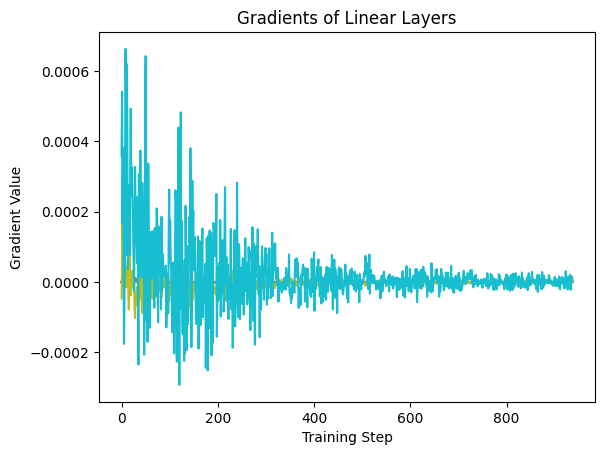

In [31]:
# Визуализируйте градиент:

fc_gradients_cpu = torch.Tensor(fc_gradients, device="cpu")

plt.plot(fc_gradients_cpu)
plt.title("Gradients of Linear Layers")
plt.xlabel("Training Step")
plt.ylabel("Gradient Value")
plt.show()

Как видите, после примерно 300 итерации градиент начал *затухать*, что означает, что веса скрытых слоев перестали обучаться. По этой причине лосс и перестал уменьшаться, т.к. градиент стал слишком мал чтобы влиять на веса слоев.

Глубокие модели (с большим числом скрытых слоев) подвержены проблеме затухания градиента, что приводит к тому, что такие модели не могут обучаться эффективно.

Одна из причин этого (в этом примере) это использования sigmoid в качестве функции активации. Давайте изменим функцию активации на ReLU и переобучим модель еще раз.

**Задача 5:** Замените sigmoid на ReLU

In [32]:
# Замените sigmoid на ReLU:
class DeepMLP_ReLU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_hidden):
        super(DeepMLP_ReLU, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_hidden)])
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.input_layer(x)
        for hidden_layer in self.hidden_layers:
            x = F.relu(hidden_layer(x))
        x = self.output_layer(x)
        return x

**Вопрос:** Посчитайте и выведите сумму всех выходов модели для рандмного входного тензора test_input

**Пример ответа:** `0.234`

In [33]:
# Инициализируйте модель с ReLU:
torch.manual_seed(42)

input_size = 28 * 28
hidden_size = 32
output_size = 10
n_hidden=10
model_relu = DeepMLP_ReLU(input_size, hidden_size, output_size, n_hidden).to(device)

In [34]:
torch.manual_seed(42)
test_input = torch.rand(1, 28*28).to(device)
answer = model(test_input).sum()
answer   ### здесь должен быть выведен ответ

tensor(-0.2574, device='cuda:0', grad_fn=<SumBackward0>)

In [35]:
# Обучите модель с ReLU:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_relu.parameters(), lr=0.01)

fc_gradients = train(model_relu, trainloader, criterion, optimizer)

  1%|          | 10/938 [00:00<00:21, 43.44it/s]

Step: 0, Loss: 2.3037009239196777
Step: 10, Loss: 2.2954561710357666


  3%|▎         | 29/938 [00:00<00:15, 58.42it/s]

Step: 20, Loss: 2.302825689315796
Step: 30, Loss: 2.304784059524536


  5%|▌         | 50/938 [00:00<00:15, 58.02it/s]

Step: 40, Loss: 2.2691526412963867
Step: 50, Loss: 2.2142844200134277


  8%|▊         | 73/938 [00:01<00:13, 63.80it/s]

Step: 60, Loss: 1.9159643650054932
Step: 70, Loss: 1.9696029424667358


  9%|▉         | 89/938 [00:01<00:12, 65.48it/s]

Step: 80, Loss: 1.8537713289260864
Step: 90, Loss: 1.8757920265197754


 12%|█▏        | 110/938 [00:01<00:13, 62.12it/s]

Step: 100, Loss: 1.755249261856079
Step: 110, Loss: 1.9241080284118652


 14%|█▍        | 132/938 [00:02<00:12, 64.56it/s]

Step: 120, Loss: 1.6213148832321167
Step: 130, Loss: 1.592047929763794


 16%|█▌        | 147/938 [00:02<00:12, 64.34it/s]

Step: 140, Loss: 1.6301336288452148
Step: 150, Loss: 1.4148064851760864


 18%|█▊        | 170/938 [00:02<00:11, 67.06it/s]

Step: 160, Loss: 1.3613747358322144
Step: 170, Loss: 1.7583119869232178


 20%|██        | 191/938 [00:03<00:11, 63.44it/s]

Step: 180, Loss: 1.4944343566894531
Step: 190, Loss: 1.3037604093551636


 23%|██▎       | 213/938 [00:03<00:11, 63.18it/s]

Step: 200, Loss: 1.3115638494491577
Step: 210, Loss: 1.5537954568862915


 24%|██▍       | 227/938 [00:03<00:11, 61.64it/s]

Step: 220, Loss: 1.300612211227417
Step: 230, Loss: 1.347327709197998


 27%|██▋       | 249/938 [00:04<00:11, 60.98it/s]

Step: 240, Loss: 1.8815038204193115
Step: 250, Loss: 1.3414229154586792


 29%|██▉       | 272/938 [00:04<00:10, 64.79it/s]

Step: 260, Loss: 1.6142351627349854
Step: 270, Loss: 1.4904329776763916


 30%|███       | 286/938 [00:04<00:10, 62.37it/s]

Step: 280, Loss: 2.08734130859375
Step: 290, Loss: 2.2944140434265137


 33%|███▎      | 308/938 [00:04<00:10, 60.88it/s]

Step: 300, Loss: 1.989254355430603
Step: 310, Loss: 1.7364696264266968


 35%|███▌      | 330/938 [00:05<00:09, 62.75it/s]

Step: 320, Loss: 1.6963292360305786
Step: 330, Loss: 1.570088505744934


 38%|███▊      | 352/938 [00:05<00:09, 64.85it/s]

Step: 340, Loss: 1.4915575981140137
Step: 350, Loss: 1.6097455024719238


 39%|███▉      | 368/938 [00:05<00:08, 65.10it/s]

Step: 360, Loss: 1.5979137420654297
Step: 370, Loss: 1.5623785257339478


 42%|████▏     | 390/938 [00:06<00:08, 66.38it/s]

Step: 380, Loss: 1.485694408416748
Step: 390, Loss: 1.3820677995681763


 44%|████▍     | 411/938 [00:06<00:08, 64.77it/s]

Step: 400, Loss: 1.5611592531204224
Step: 410, Loss: 1.4013158082962036


 45%|████▌     | 426/938 [00:06<00:07, 66.57it/s]

Step: 420, Loss: 1.451932668685913
Step: 430, Loss: 1.3206346035003662


 48%|████▊     | 449/938 [00:07<00:07, 64.96it/s]

Step: 440, Loss: 1.4083579778671265
Step: 450, Loss: 1.3467603921890259


 50%|█████     | 470/938 [00:07<00:07, 62.43it/s]

Step: 460, Loss: 1.388302206993103
Step: 470, Loss: 1.1975218057632446


 53%|█████▎    | 494/938 [00:07<00:06, 66.26it/s]

Step: 480, Loss: 1.322036862373352
Step: 490, Loss: 1.2698763608932495


 54%|█████▍    | 508/938 [00:08<00:06, 65.50it/s]

Step: 500, Loss: 1.2775744199752808
Step: 510, Loss: 1.5005029439926147


 57%|█████▋    | 531/938 [00:08<00:06, 64.25it/s]

Step: 520, Loss: 1.6284371614456177
Step: 530, Loss: 1.3923218250274658


 58%|█████▊    | 546/938 [00:08<00:05, 65.70it/s]

Step: 540, Loss: 1.2296490669250488


 60%|█████▉    | 559/938 [00:09<00:07, 49.55it/s]

Step: 550, Loss: 1.216318130493164


 61%|██████    | 570/938 [00:09<00:07, 47.47it/s]

Step: 560, Loss: 1.3948431015014648


 61%|██████▏   | 576/938 [00:09<00:07, 47.92it/s]

Step: 570, Loss: 1.504318118095398
Step: 580, Loss: 1.2066500186920166


 64%|██████▍   | 598/938 [00:09<00:07, 46.83it/s]

Step: 590, Loss: 1.6481425762176514


 65%|██████▍   | 608/938 [00:10<00:07, 43.33it/s]

Step: 600, Loss: 1.1961365938186646


 66%|██████▌   | 618/938 [00:10<00:07, 41.64it/s]

Step: 610, Loss: 1.1553452014923096


 67%|██████▋   | 624/938 [00:10<00:07, 42.09it/s]

Step: 620, Loss: 1.3278205394744873


 68%|██████▊   | 635/938 [00:10<00:07, 42.40it/s]

Step: 630, Loss: 1.9986506700515747


 69%|██████▉   | 646/938 [00:11<00:06, 44.02it/s]

Step: 640, Loss: 1.1789354085922241


 70%|██████▉   | 656/938 [00:11<00:06, 42.44it/s]

Step: 650, Loss: 1.118448257446289


 71%|███████   | 665/938 [00:11<00:07, 36.04it/s]

Step: 660, Loss: 1.355739951133728


 72%|███████▏  | 679/938 [00:11<00:05, 48.23it/s]

Step: 670, Loss: 1.2797014713287354
Step: 680, Loss: 1.4839719533920288


 75%|███████▍  | 700/938 [00:12<00:04, 56.78it/s]

Step: 690, Loss: 1.3770241737365723
Step: 700, Loss: 1.576735019683838


 77%|███████▋  | 722/938 [00:12<00:03, 61.61it/s]

Step: 710, Loss: 1.2814499139785767
Step: 720, Loss: 4.790157318115234


 79%|███████▉  | 743/938 [00:12<00:03, 64.17it/s]

Step: 730, Loss: 1.3061635494232178
Step: 740, Loss: 1.2562466859817505


 81%|████████  | 758/938 [00:13<00:02, 62.71it/s]

Step: 750, Loss: 1.035500168800354
Step: 760, Loss: 1.2243064641952515


 83%|████████▎ | 780/938 [00:13<00:02, 63.77it/s]

Step: 770, Loss: 1.2910391092300415
Step: 780, Loss: 1.197306513786316


 86%|████████▌ | 802/938 [00:13<00:02, 63.81it/s]

Step: 790, Loss: 1.270922064781189
Step: 800, Loss: 1.152504563331604


 88%|████████▊ | 823/938 [00:14<00:01, 63.23it/s]

Step: 810, Loss: 1.0426437854766846
Step: 820, Loss: 1.4269789457321167


 89%|████████▉ | 837/938 [00:14<00:01, 61.05it/s]

Step: 830, Loss: 1.0927705764770508
Step: 840, Loss: 1.0427659749984741


 92%|█████████▏| 859/938 [00:14<00:01, 62.88it/s]

Step: 850, Loss: 1.4467620849609375
Step: 860, Loss: 0.9785715341567993


 94%|█████████▍| 881/938 [00:14<00:00, 65.88it/s]

Step: 870, Loss: 1.0249103307724
Step: 880, Loss: 0.9940614104270935


 96%|█████████▋| 903/938 [00:15<00:00, 63.41it/s]

Step: 890, Loss: 1.119301438331604
Step: 900, Loss: 1.4805970191955566


 98%|█████████▊| 918/938 [00:15<00:00, 66.07it/s]

Step: 910, Loss: 1.1320809125900269
Step: 920, Loss: 0.9201682806015015


100%|██████████| 938/938 [00:15<00:00, 59.13it/s]

Step: 930, Loss: 1.3256943225860596


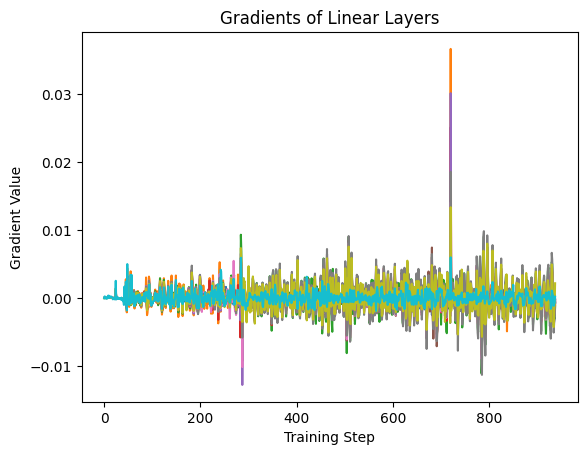

In [37]:
# Визуализируйте градиент:
fc_gradients_cpu = torch.tensor(fc_gradients, device="cpu")
plt.plot(fc_gradients_cpu)

plt.title("Gradients of Linear Layers")
plt.xlabel("Training Step")
plt.ylabel("Gradient Value")
plt.show()

Вы должны получить лосс в диапазоне 1.3-1.6. Проблема затухания градиента должна уменьшится, но не решиться полностью. Обучение глубоких нейронных сетей является нетривиальной задачей!

# Проблема взрыва градиента

Это проблема противоположна предыдущей. Вместо стремления градиента к 0, и потери способности изменять веса слоев (а значит и обучаться), градиент может "взорваться" (его значения стремятся к большим числам), что приводит к очень большим и резким изменениям весов модели, не позволяя модели сходиться.

**Задача 6:** Инициализируйте модель еще раз со следующими входными параметрами.

In [38]:
torch.manual_seed(42)

# Инициализация модели, лосс функции и оптимайзера:
input_size = 28 * 28 # MNIST image size
hidden_size = 512
output_size = 10
n_hidden=20
model = DeepMLP(input_size, hidden_size, output_size, n_hidden).to(device)

**Вопрос:** Посчитайте и выведите сумму всех выходов модели для рандмного входного тензора test_input (да да, еще раз)

**Пример ответа:** `0.234`

In [39]:
torch.manual_seed(42)
test_input = torch.rand(1, 28*28).to(device)
answer = model(test_input).sum()
answer   ### здесь должен быть выведен ответ

tensor(-0.9367, device='cuda:0', grad_fn=<SumBackward0>)

In [40]:
# Обучите модель еще раз:
torch.manual_seed(42)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

fc_gradients = train(model, trainloader, criterion, optimizer)

  1%|          | 8/938 [00:00<00:22, 40.86it/s]

Step: 0, Loss: 2.370612144470215
Step: 10, Loss: 2.319352149963379


  3%|▎         | 27/938 [00:00<00:16, 56.16it/s]

Step: 20, Loss: 2.384559392929077
Step: 30, Loss: 2.322371482849121


  6%|▌         | 52/938 [00:00<00:15, 58.56it/s]

Step: 40, Loss: 2.3334951400756836
Step: 50, Loss: 2.335846185684204


  8%|▊         | 71/938 [00:01<00:14, 58.04it/s]

Step: 60, Loss: 2.337700843811035
Step: 70, Loss: 2.294940948486328


 10%|▉         | 90/938 [00:01<00:14, 57.65it/s]

Step: 80, Loss: 2.3135998249053955
Step: 90, Loss: 2.3037660121917725


 12%|█▏        | 110/938 [00:01<00:13, 59.24it/s]

Step: 100, Loss: 2.3035049438476562
Step: 110, Loss: 2.311680316925049


 14%|█▍        | 129/938 [00:02<00:13, 60.29it/s]

Step: 120, Loss: 2.2950565814971924
Step: 130, Loss: 2.2916624546051025


 16%|█▌        | 148/938 [00:02<00:14, 55.64it/s]

Step: 140, Loss: 2.303668260574341
Step: 150, Loss: 2.308089017868042


 18%|█▊        | 167/938 [00:02<00:13, 58.91it/s]

Step: 160, Loss: 2.294508457183838
Step: 170, Loss: 2.299661636352539


 21%|██        | 193/938 [00:03<00:12, 59.10it/s]

Step: 180, Loss: 2.30952787399292
Step: 190, Loss: 2.3046488761901855


 22%|██▏       | 211/938 [00:03<00:12, 56.57it/s]

Step: 200, Loss: 2.2925260066986084
Step: 210, Loss: 2.297971725463867


 24%|██▍       | 229/938 [00:04<00:12, 57.77it/s]

Step: 220, Loss: 2.3187084197998047
Step: 230, Loss: 2.296956777572632


 26%|██▋       | 247/938 [00:04<00:12, 56.79it/s]

Step: 240, Loss: 2.320816993713379
Step: 250, Loss: 2.3015003204345703


 29%|██▉       | 273/938 [00:04<00:11, 59.79it/s]

Step: 260, Loss: 2.3070170879364014
Step: 270, Loss: 2.304478406906128


 31%|███       | 292/938 [00:05<00:10, 59.50it/s]

Step: 280, Loss: 2.3052568435668945
Step: 290, Loss: 2.3059661388397217


 33%|███▎      | 311/938 [00:05<00:10, 58.90it/s]

Step: 300, Loss: 2.3120131492614746
Step: 310, Loss: 2.291264057159424


 35%|███▌      | 330/938 [00:05<00:10, 59.54it/s]

Step: 320, Loss: 2.298677682876587
Step: 330, Loss: 2.296095609664917


 37%|███▋      | 349/938 [00:06<00:09, 58.96it/s]

Step: 340, Loss: 2.305849313735962
Step: 350, Loss: 2.3076021671295166


 39%|███▉      | 367/938 [00:06<00:12, 47.13it/s]

Step: 360, Loss: 2.2834110260009766


 40%|████      | 378/938 [00:06<00:12, 45.79it/s]

Step: 370, Loss: 2.298788547515869


 41%|████▏     | 389/938 [00:07<00:12, 42.95it/s]

Step: 380, Loss: 2.303243398666382


 42%|████▏     | 394/938 [00:07<00:13, 40.17it/s]

Step: 390, Loss: 2.30169415473938


 44%|████▎     | 410/938 [00:07<00:12, 43.53it/s]

Step: 400, Loss: 2.3153207302093506


 44%|████▍     | 415/938 [00:07<00:13, 39.60it/s]

Step: 410, Loss: 2.3035590648651123


 46%|████▌     | 430/938 [00:08<00:12, 40.23it/s]

Step: 420, Loss: 2.306709051132202


 46%|████▋     | 436/938 [00:08<00:11, 42.01it/s]

Step: 430, Loss: 2.301382064819336


 48%|████▊     | 446/938 [00:08<00:12, 38.49it/s]

Step: 440, Loss: 2.3099207878112793


 49%|████▊     | 455/938 [00:08<00:11, 40.81it/s]

Step: 450, Loss: 2.3080391883850098


 50%|████▉     | 468/938 [00:09<00:12, 37.41it/s]

Step: 460, Loss: 2.2981133460998535


 51%|█████     | 477/938 [00:09<00:12, 37.14it/s]

Step: 470, Loss: 2.296691417694092


 52%|█████▏    | 488/938 [00:09<00:10, 44.16it/s]

Step: 480, Loss: 2.2905995845794678
Step: 490, Loss: 2.301241874694824


 55%|█████▍    | 512/938 [00:09<00:08, 53.09it/s]

Step: 500, Loss: 2.303941249847412
Step: 510, Loss: 2.3054370880126953


 57%|█████▋    | 531/938 [00:10<00:06, 58.39it/s]

Step: 520, Loss: 2.295976161956787
Step: 530, Loss: 2.29780912399292


 59%|█████▊    | 549/938 [00:10<00:06, 58.05it/s]

Step: 540, Loss: 2.3027031421661377
Step: 550, Loss: 2.3001866340637207


 60%|██████    | 567/938 [00:10<00:06, 56.83it/s]

Step: 560, Loss: 2.296241283416748
Step: 570, Loss: 2.3105454444885254


 63%|██████▎   | 592/938 [00:11<00:05, 57.85it/s]

Step: 580, Loss: 2.3034372329711914
Step: 590, Loss: 2.313382625579834


 65%|██████▌   | 610/938 [00:11<00:05, 56.23it/s]

Step: 600, Loss: 2.293776750564575
Step: 610, Loss: 2.31894588470459


 67%|██████▋   | 628/938 [00:12<00:05, 54.75it/s]

Step: 620, Loss: 2.3001785278320312
Step: 630, Loss: 2.309185266494751


 68%|██████▊   | 641/938 [00:12<00:05, 58.91it/s]

Step: 640, Loss: 2.2854819297790527


 70%|███████   | 658/938 [00:12<00:07, 39.15it/s]

Step: 650, Loss: 2.299595355987549


 71%|███████▏  | 670/938 [00:13<00:05, 46.07it/s]

Step: 660, Loss: 2.3087782859802246
Step: 670, Loss: 2.292625665664673


 73%|███████▎  | 689/938 [00:13<00:04, 53.22it/s]

Step: 680, Loss: 2.312490224838257
Step: 690, Loss: 2.3027215003967285


 75%|███████▌  | 708/938 [00:13<00:04, 56.30it/s]

Step: 700, Loss: 2.3031020164489746
Step: 710, Loss: 2.2977705001831055


 78%|███████▊  | 732/938 [00:14<00:03, 57.31it/s]

Step: 720, Loss: 2.310284376144409
Step: 730, Loss: 2.3078012466430664


 80%|███████▉  | 750/938 [00:14<00:03, 57.48it/s]

Step: 740, Loss: 2.2944319248199463
Step: 750, Loss: 2.296509027481079


 81%|████████  | 762/938 [00:14<00:03, 44.43it/s]

Step: 760, Loss: 2.3016974925994873


 83%|████████▎ | 775/938 [00:15<00:04, 33.87it/s]

Step: 770, Loss: 2.315286636352539


 84%|████████▍ | 788/938 [00:15<00:04, 36.82it/s]

Step: 780, Loss: 2.292431116104126


 85%|████████▌ | 800/938 [00:15<00:02, 46.32it/s]

Step: 790, Loss: 2.2961673736572266
Step: 800, Loss: 2.297883987426758


 87%|████████▋ | 819/938 [00:16<00:02, 52.43it/s]

Step: 810, Loss: 2.3135786056518555
Step: 820, Loss: 2.307420253753662


 89%|████████▉ | 837/938 [00:16<00:01, 55.49it/s]

Step: 830, Loss: 2.3165266513824463
Step: 840, Loss: 2.305375337600708


 91%|█████████▏| 856/938 [00:16<00:01, 54.94it/s]

Step: 850, Loss: 2.3068716526031494
Step: 860, Loss: 2.3002524375915527


 94%|█████████▍| 880/938 [00:17<00:01, 48.26it/s]

Step: 870, Loss: 2.2848072052001953
Step: 880, Loss: 2.3027474880218506


 96%|█████████▌| 898/938 [00:17<00:00, 47.99it/s]

Step: 890, Loss: 2.299281358718872


 96%|█████████▋| 903/938 [00:17<00:00, 44.35it/s]

Step: 900, Loss: 2.303833246231079


 98%|█████████▊| 917/938 [00:18<00:00, 36.01it/s]

Step: 910, Loss: 2.2965760231018066


 99%|█████████▊| 925/938 [00:18<00:00, 35.33it/s]

Step: 920, Loss: 2.2989602088928223


100%|█████████▉| 934/938 [00:18<00:00, 38.74it/s]

Step: 930, Loss: 2.294469118118286


100%|██████████| 938/938 [00:18<00:00, 49.85it/s]


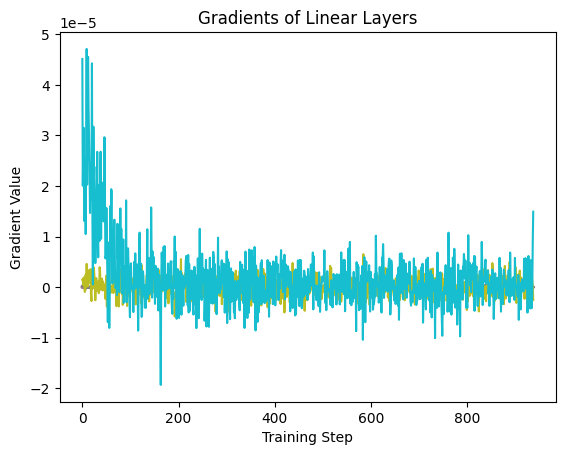

In [41]:
# Визуализируйте градиент:
fc_gradients_cpu = torch.tensor(fc_gradients, device="cpu")
plt.plot(fc_gradients_cpu)

plt.title("Gradients of Linear Layers")
plt.xlabel("Training Step")
plt.ylabel("Gradient Value")
plt.show()

Как видите, магнитуда градиента стала слишком большой, что приводит к тому, что модель не может сойтись (достичь минимума).

# ResNet

Теперь давайте попробуем реализовать модель ResNet. Ее авторы нашли способ как бороться с проблемой затухания градиента в глубоких сетях используя так называемые shortcut (или residual) связи между слоями.

**Задача 7:** Определите Residual Block

In [42]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride), nn.BatchNorm2d(out_channels))

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

**Вопрос:** Посчитайте и выведите сумму выходов ResidualBlock(10,10) для рандомного входного тензора test_input.

**Пример ответа:** `1.234`

In [43]:
torch.manual_seed(42)
test_input = torch.rand((1, 10, 3, 28*28))
res_block = ResidualBlock(10, 10)
answer = res_block(test_input).sum()
answer   ### здесь должен быть выведен ответ

tensor(16789.0645, grad_fn=<SumBackward0>)

**Задача 8:** Теперь определите модель ResNet, состоящую из нескольких ResidualBlock

In [44]:
class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.layer1 = self._make_layer(64, 64, 2)
        self.layer2 = self._make_layer(64, 128, 2)
        self.layer3 = self._make_layer(128, 256, 2)
        self.fc = nn.Linear(2304, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride=1):
        layers = []
        for i in range(num_blocks):
            if i == 0:
                layers.append(ResidualBlock(in_channels, out_channels, stride))
            else:
                layers.append(ResidualBlock(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

**Вопрос:** Посчитайте и выведите количество параметров (весов) этой ResNet модели

**Пример ответа:** `43242`

In [45]:
model = ResNet()
answer = sum(p.numel() for p in model.parameters() if p.requires_grad)
answer   ### здесь должен быть выведен ответ

2799114

In [46]:
# Инициализируем объект класса модели ResNet, а также лосс функцию и оптимайзер:
torch.manual_seed(42)

model = ResNet().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [47]:
# Теперь обучите эту модель:
torch.manual_seed(42)

model.train()

fc_gradients = []

for step, data in tqdm(enumerate(trainloader), total=len(trainloader)):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    loss.backward()
    optimizer.step()

    if step % 10 == 0:
      print(f'Step: {step}, Loss: {loss}')

    fc_gradients.append(model.fc.weight.grad.mean().item())

  0%|          | 2/938 [00:01<08:43,  1.79it/s]

Step: 0, Loss: 2.4625658988952637


  1%|▏         | 12/938 [00:02<02:05,  7.37it/s]

Step: 10, Loss: 4.5224456787109375


  2%|▏         | 22/938 [00:03<01:57,  7.78it/s]

Step: 20, Loss: 1.7724374532699585


  3%|▎         | 32/938 [00:05<01:56,  7.76it/s]

Step: 30, Loss: 1.150478720664978


  4%|▍         | 42/938 [00:06<01:56,  7.72it/s]

Step: 40, Loss: 1.155129313468933


  6%|▌         | 52/938 [00:07<01:54,  7.71it/s]

Step: 50, Loss: 0.9399275183677673


  7%|▋         | 62/938 [00:09<01:53,  7.72it/s]

Step: 60, Loss: 0.29736271500587463


  8%|▊         | 72/938 [00:10<01:52,  7.72it/s]

Step: 70, Loss: 0.3787356913089752


  9%|▊         | 82/938 [00:11<01:52,  7.59it/s]

Step: 80, Loss: 0.4742182791233063


 10%|▉         | 92/938 [00:13<01:54,  7.39it/s]

Step: 90, Loss: 0.47676682472229004


 11%|█         | 102/938 [00:14<01:55,  7.25it/s]

Step: 100, Loss: 0.5050936937332153


 12%|█▏        | 112/938 [00:15<01:49,  7.57it/s]

Step: 110, Loss: 0.49735939502716064


 13%|█▎        | 122/938 [00:17<01:47,  7.57it/s]

Step: 120, Loss: 0.42564043402671814


 14%|█▍        | 132/938 [00:18<01:46,  7.54it/s]

Step: 130, Loss: 0.29170480370521545


 15%|█▌        | 142/938 [00:19<01:45,  7.58it/s]

Step: 140, Loss: 0.23685383796691895


 16%|█▌        | 152/938 [00:20<01:44,  7.51it/s]

Step: 150, Loss: 0.07545114308595657


 17%|█▋        | 162/938 [00:22<01:43,  7.51it/s]

Step: 160, Loss: 0.23860296607017517


 18%|█▊        | 172/938 [00:23<01:41,  7.53it/s]

Step: 170, Loss: 0.32095739245414734


 19%|█▉        | 182/938 [00:24<01:39,  7.60it/s]

Step: 180, Loss: 0.2224486768245697


 20%|██        | 192/938 [00:26<01:43,  7.22it/s]

Step: 190, Loss: 0.14766593277454376


 22%|██▏       | 202/938 [00:27<01:38,  7.49it/s]

Step: 200, Loss: 0.09937464445829391


 23%|██▎       | 212/938 [00:28<01:35,  7.63it/s]

Step: 210, Loss: 0.3295857608318329


 24%|██▎       | 222/938 [00:30<01:33,  7.69it/s]

Step: 220, Loss: 0.14231149852275848


 25%|██▍       | 232/938 [00:31<01:32,  7.64it/s]

Step: 230, Loss: 0.12739737331867218


 26%|██▌       | 242/938 [00:32<01:30,  7.66it/s]

Step: 240, Loss: 0.03216850012540817


 27%|██▋       | 252/938 [00:34<01:29,  7.70it/s]

Step: 250, Loss: 0.060585346072912216


 28%|██▊       | 262/938 [00:35<01:27,  7.77it/s]

Step: 260, Loss: 0.17921584844589233


 29%|██▉       | 272/938 [00:36<01:26,  7.74it/s]

Step: 270, Loss: 0.04559553414583206


 30%|███       | 282/938 [00:38<01:27,  7.50it/s]

Step: 280, Loss: 0.12706400454044342


 31%|███       | 292/938 [00:39<01:24,  7.64it/s]

Step: 290, Loss: 0.08946273475885391


 32%|███▏      | 302/938 [00:40<01:27,  7.29it/s]

Step: 300, Loss: 0.22174054384231567


 33%|███▎      | 312/938 [00:42<01:20,  7.78it/s]

Step: 310, Loss: 0.14441141486167908


 34%|███▍      | 322/938 [00:43<01:19,  7.79it/s]

Step: 320, Loss: 0.2618865966796875


 35%|███▌      | 332/938 [00:44<01:17,  7.83it/s]

Step: 330, Loss: 0.04362364858388901


 36%|███▋      | 342/938 [00:45<01:20,  7.40it/s]

Step: 340, Loss: 0.10985811799764633


 38%|███▊      | 352/938 [00:47<01:23,  7.05it/s]

Step: 350, Loss: 0.05114763230085373


 39%|███▊      | 362/938 [00:48<01:15,  7.62it/s]

Step: 360, Loss: 0.16794703900814056


 40%|███▉      | 372/938 [00:50<01:12,  7.81it/s]

Step: 370, Loss: 0.026253480464220047


 41%|████      | 382/938 [00:51<01:12,  7.72it/s]

Step: 380, Loss: 0.0707227885723114


 42%|████▏     | 392/938 [00:52<01:10,  7.73it/s]

Step: 390, Loss: 0.23980596661567688


 43%|████▎     | 402/938 [00:53<01:08,  7.80it/s]

Step: 400, Loss: 0.1662294715642929


 44%|████▍     | 412/938 [00:55<01:07,  7.84it/s]

Step: 410, Loss: 0.02338755875825882


 45%|████▍     | 422/938 [00:56<01:05,  7.85it/s]

Step: 420, Loss: 0.15638092160224915


 46%|████▌     | 432/938 [00:57<01:04,  7.83it/s]

Step: 430, Loss: 0.03576989099383354


 47%|████▋     | 442/938 [00:59<01:04,  7.74it/s]

Step: 440, Loss: 0.12358137220144272


 48%|████▊     | 452/938 [01:00<01:01,  7.87it/s]

Step: 450, Loss: 0.1723095178604126


 49%|████▉     | 462/938 [01:01<01:00,  7.89it/s]

Step: 460, Loss: 0.04628082364797592


 50%|█████     | 472/938 [01:02<01:02,  7.51it/s]

Step: 470, Loss: 0.052940551191568375


 51%|█████▏    | 482/938 [01:04<00:59,  7.61it/s]

Step: 480, Loss: 0.14339418709278107


 52%|█████▏    | 492/938 [01:05<00:57,  7.76it/s]

Step: 490, Loss: 0.07270035147666931


 54%|█████▎    | 502/938 [01:06<00:55,  7.85it/s]

Step: 500, Loss: 0.17633570730686188


 55%|█████▍    | 512/938 [01:08<00:54,  7.83it/s]

Step: 510, Loss: 0.04145992547273636


 56%|█████▌    | 522/938 [01:09<00:53,  7.85it/s]

Step: 520, Loss: 0.15059319138526917


 57%|█████▋    | 532/938 [01:10<00:51,  7.82it/s]

Step: 530, Loss: 0.12602736055850983


 58%|█████▊    | 542/938 [01:11<00:50,  7.82it/s]

Step: 540, Loss: 0.10043540596961975


 59%|█████▉    | 552/938 [01:13<00:49,  7.86it/s]

Step: 550, Loss: 0.05626778304576874


 60%|█████▉    | 562/938 [01:14<00:48,  7.83it/s]

Step: 560, Loss: 0.029173174872994423


 61%|██████    | 572/938 [01:15<00:49,  7.43it/s]

Step: 570, Loss: 0.1035410687327385


 62%|██████▏   | 582/938 [01:17<00:46,  7.61it/s]

Step: 580, Loss: 0.24847806990146637


 63%|██████▎   | 592/938 [01:18<00:44,  7.79it/s]

Step: 590, Loss: 0.44603022933006287


 64%|██████▍   | 602/938 [01:19<00:42,  7.83it/s]

Step: 600, Loss: 0.15346500277519226


 65%|██████▌   | 612/938 [01:20<00:41,  7.79it/s]

Step: 610, Loss: 0.025048753246665


 66%|██████▋   | 622/938 [01:22<00:40,  7.83it/s]

Step: 620, Loss: 0.08190996944904327


 67%|██████▋   | 632/938 [01:23<00:39,  7.79it/s]

Step: 630, Loss: 0.2816358804702759


 68%|██████▊   | 642/938 [01:24<00:38,  7.73it/s]

Step: 640, Loss: 0.013747546821832657


 70%|██████▉   | 652/938 [01:26<00:37,  7.71it/s]

Step: 650, Loss: 0.07695801556110382


 71%|███████   | 662/938 [01:27<00:35,  7.77it/s]

Step: 660, Loss: 0.0830705389380455


 72%|███████▏  | 672/938 [01:28<00:35,  7.51it/s]

Step: 670, Loss: 0.053230419754981995


 73%|███████▎  | 682/938 [01:30<00:34,  7.46it/s]

Step: 680, Loss: 0.10812824964523315


 74%|███████▍  | 692/938 [01:31<00:31,  7.77it/s]

Step: 690, Loss: 0.19023706018924713


 75%|███████▍  | 702/938 [01:32<00:31,  7.60it/s]

Step: 700, Loss: 0.03532952442765236


 76%|███████▌  | 712/938 [01:33<00:29,  7.54it/s]

Step: 710, Loss: 0.14728432893753052


 77%|███████▋  | 722/938 [01:35<00:27,  7.73it/s]

Step: 720, Loss: 0.037050358951091766


 78%|███████▊  | 732/938 [01:36<00:26,  7.80it/s]

Step: 730, Loss: 0.1074243113398552


 79%|███████▉  | 742/938 [01:37<00:25,  7.75it/s]

Step: 740, Loss: 0.04546922445297241


 80%|████████  | 752/938 [01:39<00:23,  7.79it/s]

Step: 750, Loss: 0.029710855334997177


 81%|████████  | 762/938 [01:40<00:22,  7.74it/s]

Step: 760, Loss: 0.052953120321035385


 82%|████████▏ | 772/938 [01:41<00:22,  7.45it/s]

Step: 770, Loss: 0.0776807963848114


 83%|████████▎ | 782/938 [01:43<00:20,  7.61it/s]

Step: 780, Loss: 0.11135240644216537


 84%|████████▍ | 792/938 [01:44<00:18,  7.74it/s]

Step: 790, Loss: 0.13656815886497498


 86%|████████▌ | 802/938 [01:45<00:17,  7.66it/s]

Step: 800, Loss: 0.09588033705949783


 87%|████████▋ | 812/938 [01:47<00:16,  7.68it/s]

Step: 810, Loss: 0.020747078582644463


 88%|████████▊ | 822/938 [01:48<00:15,  7.46it/s]

Step: 820, Loss: 0.14518970251083374


 89%|████████▊ | 832/938 [01:49<00:13,  7.71it/s]

Step: 830, Loss: 0.08516889810562134


 90%|████████▉ | 842/938 [01:50<00:12,  7.67it/s]

Step: 840, Loss: 0.20529277622699738


 91%|█████████ | 852/938 [01:52<00:11,  7.77it/s]

Step: 850, Loss: 0.1030835434794426


 92%|█████████▏| 862/938 [01:53<00:09,  7.67it/s]

Step: 860, Loss: 0.06274846196174622


 93%|█████████▎| 872/938 [01:54<00:09,  7.27it/s]

Step: 870, Loss: 0.14224882423877716


 94%|█████████▍| 882/938 [01:56<00:07,  7.72it/s]

Step: 880, Loss: 0.018638553097844124


 95%|█████████▌| 892/938 [01:57<00:05,  7.77it/s]

Step: 890, Loss: 0.027046164497733116


 96%|█████████▌| 902/938 [01:58<00:04,  7.65it/s]

Step: 900, Loss: 0.16001227498054504


 97%|█████████▋| 912/938 [02:00<00:03,  7.76it/s]

Step: 910, Loss: 0.11052557826042175


 98%|█████████▊| 922/938 [02:01<00:02,  7.70it/s]

Step: 920, Loss: 0.04278616979718208


 99%|█████████▉| 932/938 [02:02<00:00,  7.70it/s]

Step: 930, Loss: 0.182723268866539


100%|██████████| 938/938 [02:03<00:00,  7.60it/s]


Как можете видеть, лосс продолжает уменьшаться. Теперь попробуйте визиулизировать градиент накопленный в переменной fc_gradients

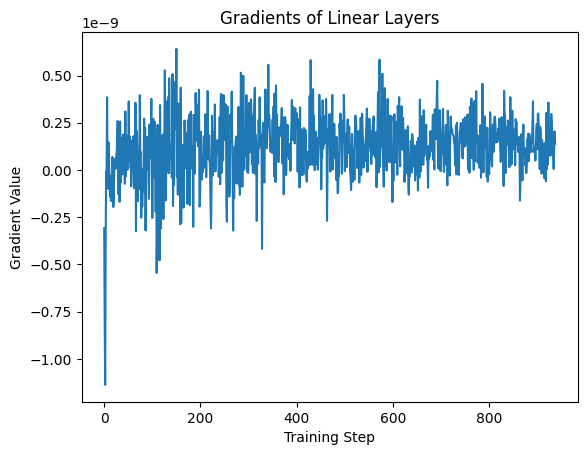

In [48]:
# Визуализируйте градиент:
fc_gradients_cpu = torch.tensor(fc_gradients, device="cpu")
plt.plot(fc_gradients_cpu)

plt.title("Gradients of Linear Layers")
plt.xlabel("Training Step")
plt.ylabel("Gradient Value")
plt.show()

Теперь градиент кажется достаточно стабильным, и это позволяет ResNet модели обучаться лучше предыдущей модели, которая была подвержена проблеме затухания градента. Таким способом ResNet стала SOTA моделью в 2015 году и выиграла ImageNet competition.

Наконец, давайте сохраним параметры (веса) обученной модели чтобы переиспользовать их позже:

In [49]:
checkpoint_path = './mnist_checkpoint.pth'
torch.save(model.state_dict(), checkpoint_path)

# Transfer Learning

Перед тем как мы перейдем к технике обучения называемой Transfer Learning, давайте сперва протестируем нашу модель на тестовой подвыборке датасета MNIST. Чтобы сделать это, вам необходимо скачать тестовую подвыборку схожим образом, как вы уже скачали подвыборку для обучения с тем отличием, что нужно изменить параметр `train=False`:

In [50]:
# Загрузите тестовую подвыборку датасета MNIST:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

Теперь нам нужно имплементировать функцию для тестирования модели, в которой мы будем считать точность (accuracy) нашей модели (т.е. процент правильных предсказаний):

In [51]:
def test(model, dataloader):
  model.eval()

  with torch.no_grad():
    correct = 0

    for step, data in tqdm(enumerate(dataloader), total=len(dataloader)):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        correct += (outputs.argmax(1) == labels).type(torch.float).sum().item()

    accuracy = correct/len(dataloader.dataset)

    return accuracy

Теперь загрузите ранее сохраненные параметры (веса) обученной ResNet модели:

**Задача 9:** Посчитайте точность модели на тесте.

In [52]:
model = ResNet()
model.load_state_dict(torch.load(checkpoint_path))
model = model.to(device)

**Вопрос:** Посчитайте и выведите точность модели на тестовой выборке MNIST.

**Пример ответа:** `22.45`

In [53]:
accuracy = test(model, testloader)
print(f"\nMNIST test accuracy: {100*accuracy}%")

100%|██████████| 157/157 [00:07<00:00, 21.74it/s]


MNIST test accuracy: 97.19%


Вы должны получить точность примерно 96% или выше.

Теперь давайте попробуем загрузить другой датасет - CIFAR10, который состоит из 10 классов, но содержит изображения не рукописаных цифр, а объектов (horses, dogs, cars, и др.). Изображения имеют размер 32x32 и три цветовых канала (RGB). Поэтому нам также нужно изменить трансформации (transforms), чтобы изображения CIFAR10 соответствовали  изображениям MNIST (т.е. 28x28 в формате grayscale):

In [54]:
# Трансформации для датасета CIFAR10:
transform_cifar10 = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28,28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Выборка для обучения:
trainset_cifar10 = torchvision.datasets.CIFAR10(root='./data_cifar10', train=True, download=True, transform=transform_cifar10)
trainloader_cifar10 = torch.utils.data.DataLoader(trainset_cifar10, batch_size=64, shuffle=True, num_workers=2)

# Выборка для тестирования:
testset_cifar10 = torchvision.datasets.CIFAR10(root='./data_cifar10', train=False, download=True, transform=transform_cifar10)
testloader_cifar10 = torch.utils.data.DataLoader(testset_cifar10, batch_size=64, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:12<00:00, 13534354.55it/s]


Extracting ./data_cifar10/cifar-10-python.tar.gz to ./data_cifar10
Files already downloaded and verified


Теперь протестируйте ранее обученную ResNet модель на тестовой выборке датасета CIFAR10 (пока переобучать модель не нужно!):

**Задача 10:** Протестируйте модель на тестовой выборке CIFAR10

**Вопрос:** Посчитайте и выведите точность модели на тесте

**Пример ответа:** `22.45`

In [55]:
accuracy = test(model, testloader_cifar10)
print(f"\nTest accuracy: {100*accuracy}%")

100%|██████████| 157/157 [00:07<00:00, 21.51it/s]


Test accuracy: 9.969999999999999%


Как видите, точность на CIFAR10 не очень большая (около 10%). И это не удивительно, ведь мы обучали нашу ResNet модель на другом датасете (MNIST).

Теперь давайте заморозим все слои за исключением последнего (т.е. слоя классификации):

**Задача 11:** Заморозьте слои модели кроме последнего

In [56]:
for param in model.parameters():
    param.requires_grad = False              # отключаем градиент (т.е. "замораживаем" слои)

mnist_fc = model.fc                          # Сохраняем в переменную слой классификации MNIST
in_features = model.fc.in_features
model.fc = torch.nn.Linear(in_features, 10)  # Создаем новый слой классификации для CIFAR10
model.fc = model.fc.cuda()

**Вопрос:** Посчитайте и выведите количество параметров (весов) в замороженных слоях

**Пример ответа:** `224513`

In [59]:
frozen_params = sum(p.numel() for p in mnist_fc.parameters())
frozen_params   ### здесь должен быть выведен ответ

23050

**Задача 12:** Обучите только последний слой модели на датасете CIFAR10 (все остальные слои должны быть заморожены)

In [60]:
torch.manual_seed(42)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for step, data in tqdm(enumerate(trainloader_cifar10), total=len(trainloader_cifar10)):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    loss.backward()
    optimizer.step()

    if step % 10 == 0:
      print(f'Step: {step}, Loss: {loss}')

  1%|          | 4/782 [00:00<00:40, 19.06it/s]

Step: 0, Loss: 2.3283841609954834


  2%|▏         | 16/782 [00:00<00:35, 21.60it/s]

Step: 10, Loss: 2.458704948425293


  3%|▎         | 25/782 [00:01<00:34, 21.98it/s]

Step: 20, Loss: 2.5699760913848877


  4%|▍         | 35/782 [00:01<00:33, 22.15it/s]

Step: 30, Loss: 2.234074354171753


  6%|▌         | 45/782 [00:02<00:32, 22.59it/s]

Step: 40, Loss: 2.044296979904175


  7%|▋         | 54/782 [00:02<00:32, 22.24it/s]

Step: 50, Loss: 2.147373914718628


  8%|▊         | 66/782 [00:03<00:32, 22.04it/s]

Step: 60, Loss: 2.04306960105896


 10%|▉         | 75/782 [00:03<00:32, 21.76it/s]

Step: 70, Loss: 1.7913130521774292


 11%|█         | 85/782 [00:03<00:31, 22.21it/s]

Step: 80, Loss: 1.9071133136749268


 12%|█▏        | 94/782 [00:04<00:30, 22.29it/s]

Step: 90, Loss: 2.0821590423583984


 14%|█▎        | 106/782 [00:04<00:30, 21.84it/s]

Step: 100, Loss: 1.9337679147720337


 15%|█▍        | 115/782 [00:05<00:30, 21.69it/s]

Step: 110, Loss: 2.027862310409546


 16%|█▌        | 125/782 [00:05<00:29, 22.13it/s]

Step: 120, Loss: 1.7197285890579224


 17%|█▋        | 135/782 [00:06<00:29, 22.28it/s]

Step: 130, Loss: 2.2450003623962402


 18%|█▊        | 144/782 [00:06<00:31, 20.41it/s]

Step: 140, Loss: 2.1816558837890625


 20%|█▉        | 155/782 [00:07<00:33, 18.59it/s]

Step: 150, Loss: 1.9776073694229126


 21%|██        | 165/782 [00:07<00:31, 19.32it/s]

Step: 160, Loss: 2.0924501419067383


 22%|██▏       | 173/782 [00:08<00:37, 16.42it/s]

Step: 170, Loss: 2.0276365280151367


 23%|██▎       | 183/782 [00:08<00:32, 18.28it/s]

Step: 180, Loss: 2.0156826972961426


 25%|██▍       | 194/782 [00:09<00:33, 17.68it/s]

Step: 190, Loss: 2.131913185119629


 26%|██▌       | 204/782 [00:10<00:27, 20.90it/s]

Step: 200, Loss: 2.4117531776428223


 28%|██▊       | 216/782 [00:10<00:26, 21.01it/s]

Step: 210, Loss: 1.7498561143875122


 29%|██▉       | 225/782 [00:11<00:26, 21.36it/s]

Step: 220, Loss: 2.1291236877441406


 30%|███       | 235/782 [00:11<00:25, 21.73it/s]

Step: 230, Loss: 1.840243935585022


 31%|███▏      | 245/782 [00:12<00:24, 22.10it/s]

Step: 240, Loss: 1.9637666940689087


 32%|███▏      | 254/782 [00:12<00:24, 21.80it/s]

Step: 250, Loss: 1.9830920696258545


 34%|███▍      | 266/782 [00:13<00:24, 21.48it/s]

Step: 260, Loss: 1.9161487817764282


 35%|███▌      | 275/782 [00:13<00:24, 21.09it/s]

Step: 270, Loss: 2.081573486328125


 36%|███▋      | 284/782 [00:13<00:23, 20.84it/s]

Step: 280, Loss: 2.1447196006774902


 38%|███▊      | 296/782 [00:14<00:22, 21.17it/s]

Step: 290, Loss: 2.0399010181427


 39%|███▉      | 305/782 [00:14<00:22, 20.83it/s]

Step: 300, Loss: 2.103532314300537


 40%|████      | 314/782 [00:15<00:21, 21.53it/s]

Step: 310, Loss: 1.652994990348816


 42%|████▏     | 326/782 [00:15<00:21, 21.08it/s]

Step: 320, Loss: 2.3951258659362793


 43%|████▎     | 335/782 [00:16<00:21, 21.06it/s]

Step: 330, Loss: 1.8600176572799683


 44%|████▍     | 344/782 [00:16<00:20, 21.28it/s]

Step: 340, Loss: 1.6990342140197754


 46%|████▌     | 356/782 [00:17<00:20, 21.23it/s]

Step: 350, Loss: 2.0843071937561035


 47%|████▋     | 365/782 [00:17<00:20, 20.84it/s]

Step: 360, Loss: 1.7415128946304321


 48%|████▊     | 375/782 [00:18<00:18, 21.55it/s]

Step: 370, Loss: 1.916264533996582


 49%|████▉     | 384/782 [00:18<00:18, 21.66it/s]

Step: 380, Loss: 1.756121039390564


 51%|█████     | 396/782 [00:19<00:18, 21.15it/s]

Step: 390, Loss: 1.8903179168701172


 52%|█████▏    | 405/782 [00:19<00:17, 21.10it/s]

Step: 400, Loss: 1.683504343032837


 53%|█████▎    | 414/782 [00:20<00:17, 21.24it/s]

Step: 410, Loss: 2.244532585144043


 54%|█████▍    | 423/782 [00:20<00:17, 20.73it/s]

Step: 420, Loss: 1.6034572124481201


 56%|█████▌    | 435/782 [00:21<00:16, 20.64it/s]

Step: 430, Loss: 2.202138900756836


 57%|█████▋    | 444/782 [00:21<00:16, 20.63it/s]

Step: 440, Loss: 1.9419890642166138


 58%|█████▊    | 453/782 [00:21<00:16, 20.47it/s]

Step: 450, Loss: 2.134979724884033


 59%|█████▉    | 465/782 [00:22<00:15, 20.98it/s]

Step: 460, Loss: 1.8561033010482788


 61%|██████    | 474/782 [00:23<00:14, 20.87it/s]

Step: 470, Loss: 1.759845495223999


 62%|██████▏   | 486/782 [00:23<00:13, 21.47it/s]

Step: 480, Loss: 2.237821102142334


 63%|██████▎   | 495/782 [00:23<00:13, 21.22it/s]

Step: 490, Loss: 1.6175979375839233


 65%|██████▍   | 505/782 [00:24<00:12, 21.79it/s]

Step: 500, Loss: 2.349764108657837


 66%|██████▌   | 515/782 [00:24<00:12, 22.04it/s]

Step: 510, Loss: 2.240496873855591


 67%|██████▋   | 525/782 [00:25<00:11, 22.10it/s]

Step: 520, Loss: 2.3314459323883057


 68%|██████▊   | 535/782 [00:25<00:11, 22.33it/s]

Step: 530, Loss: 2.370199680328369


 70%|██████▉   | 544/782 [00:26<00:10, 22.17it/s]

Step: 540, Loss: 2.251244068145752


 71%|███████   | 556/782 [00:26<00:10, 21.82it/s]

Step: 550, Loss: 2.1041524410247803


 72%|███████▏  | 565/782 [00:27<00:10, 21.60it/s]

Step: 560, Loss: 1.898297667503357


 74%|███████▎  | 575/782 [00:27<00:09, 22.06it/s]

Step: 570, Loss: 2.286540985107422


 75%|███████▍  | 585/782 [00:28<00:08, 22.23it/s]

Step: 580, Loss: 2.03848934173584


 76%|███████▌  | 595/782 [00:28<00:08, 22.49it/s]

Step: 590, Loss: 2.0796244144439697


 77%|███████▋  | 605/782 [00:29<00:07, 22.48it/s]

Step: 600, Loss: 1.8054505586624146


 79%|███████▊  | 615/782 [00:29<00:07, 22.41it/s]

Step: 610, Loss: 1.7838587760925293


 80%|███████▉  | 625/782 [00:30<00:06, 22.50it/s]

Step: 620, Loss: 1.9695241451263428


 81%|████████  | 634/782 [00:30<00:06, 22.43it/s]

Step: 630, Loss: 2.232072114944458


 83%|████████▎ | 646/782 [00:30<00:06, 22.09it/s]

Step: 640, Loss: 2.170058488845825


 84%|████████▍ | 655/782 [00:31<00:05, 21.85it/s]

Step: 650, Loss: 1.8184820413589478


 85%|████████▍ | 664/782 [00:31<00:05, 22.24it/s]

Step: 660, Loss: 1.65969717502594


 86%|████████▋ | 676/782 [00:32<00:04, 21.79it/s]

Step: 670, Loss: 2.201141119003296


 88%|████████▊ | 685/782 [00:32<00:04, 19.91it/s]

Step: 680, Loss: 2.174412727355957


 89%|████████▊ | 694/782 [00:33<00:03, 22.29it/s]

Step: 690, Loss: 2.2134130001068115


 90%|████████▉ | 703/782 [00:33<00:04, 18.35it/s]

Step: 700, Loss: 1.905282974243164


 91%|█████████▏| 715/782 [00:34<00:04, 16.59it/s]

Step: 710, Loss: 2.31368088722229


 92%|█████████▏| 723/782 [00:34<00:03, 19.37it/s]

Step: 720, Loss: 2.026182174682617


 94%|█████████▍| 735/782 [00:35<00:02, 20.73it/s]

Step: 730, Loss: 2.252499580383301


 95%|█████████▌| 744/782 [00:35<00:01, 21.36it/s]

Step: 740, Loss: 1.7663500308990479


 97%|█████████▋| 756/782 [00:36<00:01, 21.86it/s]

Step: 750, Loss: 1.7634814977645874


 98%|█████████▊| 765/782 [00:36<00:00, 22.03it/s]

Step: 760, Loss: 2.0737650394439697


 99%|█████████▉| 774/782 [00:37<00:00, 22.43it/s]

Step: 770, Loss: 1.82622230052948


100%|██████████| 782/782 [00:37<00:00, 20.74it/s]

Step: 780, Loss: 1.8221032619476318


**Вопрос:** Посчитайте точность на тестовой выборке CIFAR10

**Пример ответа:** `32.45`

In [61]:
accuracy = test(model, testloader_cifar10)
print(f"\nTest accuracy: {100*accuracy}%")

100%|██████████| 157/157 [00:07<00:00, 21.43it/s]


Test accuracy: 37.79%


Как можете видеть, точность модели выросла до примерно 35%. Мы обучили только последний слой (классификации), а остальная часть сети осталось нетронутой (т.е. остальные слои обучены на датасете MNIST). Эта техника обучения и называется Transfer Learning.

Теперь протестируйте эту модель еще раз на тестовой выборке MNIST:

In [62]:
accuracy = test(model, testloader)
print(f"\nMNIST test accuracy: {100*accuracy}%")

100%|██████████| 157/157 [00:07<00:00, 21.31it/s]


MNIST test accuracy: 11.53%


Как вы можете видеть, точность упала ниже 10%, поскольку последний слой классификации теперь обучен на CIFAR10 датасете. Это называется "катастрофическим забыванием" (catastrophic forgetting). Катастрофическое забывание это тенденация нейронной сети забывать предыдущие обученные знания когда она обучается новой информации.

Наконец, давайте вернем назад ранее сохраненный слой классификации обученный на MNIST и протестируем еще раз:

**Задача 13:** Верните последний слой mnist_fc и проведите финальный тест на тестовых выборках MNIST и CIFAR10

**Вопрос:** Посчитайте и выведите точность на тестовых выборках MNIST и CIFAR10

**Пример ответа:**
`CIFAR test accuracy: 9.45`
`MNIST test accuracy: 51.68`

In [63]:
model.fc = mnist_fc                       # верните в модель слой классификации обученный на MNIST
model.fc = model.fc.cuda()                # Перенесем на cuda

accuracy = test(model, testloader_cifar10)
print(f"\nCIFAR test accuracy: {100*accuracy}%")

accuracy = test(model, testloader)
print(f"\nMNIST test accuracy: {100*accuracy}%")

100%|██████████| 157/157 [00:07<00:00, 22.06it/s]


CIFAR test accuracy: 10.5%



100%|██████████| 157/157 [00:07<00:00, 21.31it/s]


MNIST test accuracy: 73.52%
